# NLP ENDSEM Q-3 TOPIC MODELLING

## Importing libraries

In [46]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from string import punctuation

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models import CoherenceModel

import matplotlib.pyplot as plt

import re

from wordcloud import WordCloud


In [38]:
!pip install pyLDAvis


### Loading Data

In [2]:
data=pd.read_csv('../input/mobile-reviews/K8 Reviews v0.2.csv')
data.head()

,sentiment,review
0,1,Good but need updates and improvements
1,0,"Worst mobile i have bought ever, Battery is dr..."
2,1,when I will get my 10% cash back.... its alrea...
3,1,Good
4,0,The worst phone everThey have changed the last...


In [54]:
# A negative review
data[data['sentiment']==0]['review'].iloc[0]

"Worst mobile i have bought ever, Battery is draining like hell, backup is only 6 to 7 hours with internet uses, even if I put mobile idle its getting discharged.This is biggest lie from Amazon & Lenove which is not at all expected, they are making full by saying that battery is 4000MAH & booster charger is fake, it takes at least 4 to 5 hours to be fully charged.Don't know how Lenovo will survive by making full of us.Please don;t go for this else you will regret like me."

In [53]:
# A positive review
data[data['sentiment']==1]['review'].iloc[0]

'Good but need updates and improvements'

In [6]:
data['sentiment'].value_counts()

0    7712
1    6963
Name: sentiment, dtype: int64

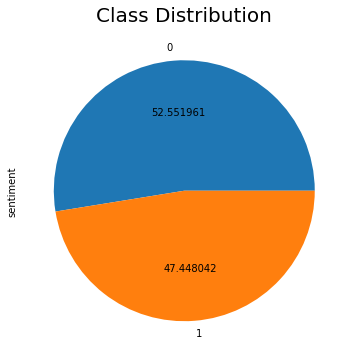

In [8]:
data['sentiment'].value_counts().plot(kind='pie',figsize=(12,6),autopct="%f")
plt.title('Class Distribution',fontsize=20)
plt.show()

In [55]:
# Unbiased class distribution

## EDA

In [14]:
def get_visuals(df,column_name,value):
    s=','
    for element in df[df[column_name]==value]['review']:
        s+=str(element)
    
    wordcloud=WordCloud(background_color='white',
                    random_state=101,
                   width=800,
                   height=800).generate(s)
    
    plt.figure(figsize=(12,8))
    plt.axis('off')
    plt.grid(False)
    plt.imshow(wordcloud)
    plt.show()
    

### Negative Sentiment Reviews

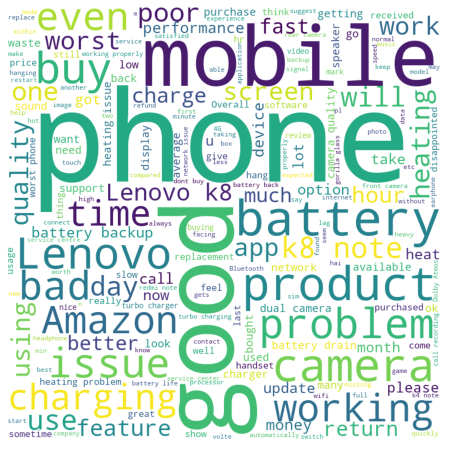

In [18]:
# Negative Sentiment WordCloud
get_visuals(data,'sentiment',0)

### Positive Sentiment Reviews

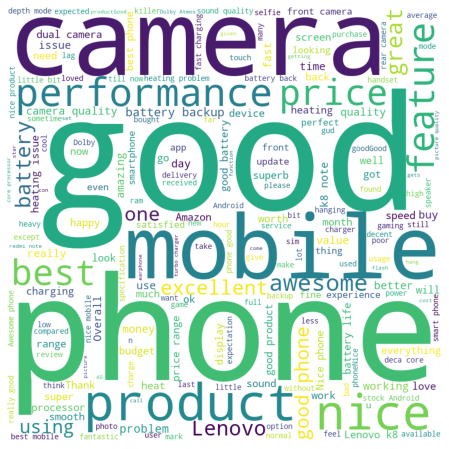

In [19]:
# Positive Sentiment WordCloud
get_visuals(data,'sentiment',1)

## Data Preparation

In [20]:
def prepare_data(df,column_name):
    data=df[column_name]
    useless_words=list(stopwords.words('english')+list(punctuation))
    
    lemmatizer=WordNetLemmatizer()
    corpus=data.tolist()
    final_corpus=[]
    
    for i in range(len(corpus)):
        word=word_tokenize(corpus[i].lower())
        word=[
            lemmatizer.lemmatize(y) for y in word if y not in useless_words
        ]
        j=" ".join(word)
        j=re.sub(r'[^\w\s]', " ", j)
        j=re.sub("(^|\W)\d+"," ",j)
        
        final_corpus.append(j)
    
    return final_corpus

In [21]:
final_corpus=prepare_data(data,'review')

label_=data['sentiment']
train_df={
    'label':label_,
    'content':final_corpus,
}

train_df=pd.DataFrame(train_df)
train_df.head()

,label,content
0,1,good need update improvement
1,0,worst mobile bought ever battery draining like...
2,1,get cash back already january
3,1,good
4,0,worst phone everthey changed last phone proble...


### Getting the 'content' column to generate topics

In [22]:
final_data=train_df['content'].map(word_tokenize)

In [23]:
final_data[:5]

0                    [good, need, update, improvement]
1    [worst, mobile, bought, ever, battery, drainin...
2                  [get, cash, back, already, january]
3                                               [good]
4    [worst, phone, everthey, changed, last, phone,...
Name: content, dtype: object

### Mapping words to their ids

In [24]:
dictionary = gensim.corpora.Dictionary(final_data)

In [25]:
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 good
1 improvement
2 need
3 update
4 amazon
5 backup
6 battery
7 biggest
8 booster
9 bought
10 charged


### Removing extreme values as it may create bias

In [26]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

In [27]:
bow_corpus = [dictionary.doc2bow(doc) for doc in final_data]


## LDA Model

In [28]:
from gensim import corpora, models

tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

In [29]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=2, workers=4)

In [30]:
for index, score in sorted(lda_model_tfidf[bow_corpus[2]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))


Score: 0.8199498057365417	 
Topic: 0.057*"nice" + 0.024*"phone" + 0.023*"product" + 0.020*"superb" + 0.018*"battery" + 0.015*"good" + 0.014*"camera" + 0.012*"problem" + 0.011*"best" + 0.010*"heating"

Score: 0.02000739425420761	 
Topic: 0.016*"phone" + 0.014*"great" + 0.013*"camera" + 0.012*"satisfied" + 0.012*"good" + 0.012*"mobile" + 0.012*"product" + 0.011*"battery" + 0.011*"lenovo" + 0.011*"nice"

Score: 0.020007014274597168	 
Topic: 0.049*"nice" + 0.026*"excellent" + 0.021*"phone" + 0.013*"mobile" + 0.010*"s" + 0.010*"working" + 0.008*"lenovo" + 0.008*"good" + 0.008*"product" + 0.008*"best"

Score: 0.0200062058866024	 
Topic: 0.048*"product" + 0.044*"good" + 0.021*"phone" + 0.014*"battery" + 0.013*"performance" + 0.011*"nice" + 0.010*"love" + 0.010*"note" + 0.009*"lenovo" + 0.008*"k8"

Score: 0.0200056005269289	 
Topic: 0.019*"great" + 0.019*"product" + 0.019*"awesome" + 0.017*"poor" + 0.017*"camera" + 0.015*"phone" + 0.015*"excellent" + 0.014*"amazing" + 0.011*"good" + 0.011*"bu

### Evaluation

In [33]:
lda_model_coherence = CoherenceModel(model=lda_model_tfidf,
                                     texts=final_data,
                                     dictionary=dictionary,
                                    coherence='c_v')

coherence_lda = lda_model_coherence.get_coherence()
print('\nCoherence Score:',coherence_lda)


Coherence Score: 0.4278055235667118


In [35]:
perplexity = lda_model_tfidf.log_perplexity(corpus_tfidf)

In [36]:
print('Perplexity for the model : ',perplexity)

Perplexity for the model :  -7.633452752596017


## Visualization Of Topics

In [45]:
import pyLDAvis
import pyLDAvis.gensim


pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model_tfidf, corpus_tfidf, dictionary)

/opt/conda/lib/python3.7/site-packages/pyLDAvis/_prepare.py:248: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.006827  0.008104       1        1  14.803061
3     -0.025168  0.025861       2        1  11.894818
9     -0.013969  0.007952       3        1  11.857598
8     -0.025002  0.034840       4        1  11.292050
5      0.011807  0.005696       5        1  10.052687
6      0.009639 -0.011790       6        1   9.160589
0     -0.003851 -0.052815       7        1   8.100529
7     -0.043621 -0.057360       8        1   7.858874
2     -0.017087  0.041765       9        1   7.589743
4      0.114079 -0.002254      10        1   7.390050, topic_info=        Term         Freq        Total Category  logprob  loglift
0       good  1156.000000  1156.000000  Default  30.0000  30.0000
211     nice   676.000000   676.000000  Default  29.0000  29.0000
59   awesome   273.000000   273.000000  Default  28.0000  28.0000
171      bad   277.000000   277.000000  Default  27.0000  27.0000
117  product   531.000000   531.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
29    lenovo    13.894313   257.777693  Topic10  -5.2854  -0.3156
64      note    12.665284   184.011386  Topic10  -5.3780  -0.0711
106     time    12.208668   160.453978  Topic10  -5.4148   0.0292
88   heating    13.048348   294.116185  Topic10  -5.3482  -0.5103
158    issue    12.254429   239.852746  Topic10  -5.4110  -0.3691

[682 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
975       1  0.147915  absolutely
975       2  0.073957  absolutely
975       3  0.073957  absolutely
975       4  0.073957  absolutely
975       6  0.073957  absolutely
...     ...       ...         ...
595       8  0.134038        zero
595       9  0.134038        zero
585       1  0.144843        zoom
585       4  0.144843        zoom
585       7  0.434528        zoom

[3067 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 10, 9, 6, 7, 1, 8, 3, 5])

## Inference

<hr>
The higher the coherence score is, better the topics are extracted. It means that interrelated words which show up in a piece of text belong to a topic, hence if coherence is high, we get better results.<br> Coherence Score : 0.427<br><br>

Perplexity is a measure of how easy a probability distribution is to predict, which implies that a lower perplexity score will indicate a better generalization performance. This value goes down as the number of topics increases.<br> Model Perplexity : -7.63<br>

<hr>
Topics:<br>
1) nice|phone|product|superb|battery|good|camera|problem|best|heating -> <strong>heating while usage</strong><br>
2) phone|great|camera|satisfied|good|mobile|product|battery|lnovo|nice -> <strong>good camera</strong><br>
3) nice|excellent|phone|mobile|s|working|lenovo|good|product|best -> <strong>good performance</strong><br>
4) product|good|phone|battery|performance|nice|love|note|lenovo|k8 -> <strong>great quality</strong><br>
5) great|product|awesome|poor|camera|phone|excellent|amazing|good|buy -> <strong>poor camera</strong><br>
6) good|phone|mobile|price|worst|best|quality|camera|product|s -> <strong>value for price</strong><br>
7) eating|super|problem|money|battery|good|charging|phone|worth|value -> <strong>good battery</strong><br>
8) mobile|good|working|ok|phone|properly|camera|battery|like|n -> <strong>average performance</strong><br>
9) bad|good|nice|camera|one|phone|quality|mobile|performance|battery -> <strong>overall negative</strong><br>
10)awesome|best|phone|good|mobile|camera|battery|average|nice|price -> <strong>overall positive</strong><br>

<hr>


